In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv("Results - Sheet1.csv")
df.columns

Index(['Model', 'comments', 'dataset', 'dataset type', 'Precision Performance',
       'Recall Performance', 'F1 performance'],
      dtype='object')

In [6]:
df[["Model", "comments", "dataset", "dataset type"]] = df[
    ["Model", "comments", "dataset", "dataset type"]
].fillna(" ")
df[["Precision Performance", "Recall Performance", "F1 performance"]] = df[
    ["Precision Performance", "Recall Performance", "F1 performance"]
].fillna(0)

In [7]:
model = "ELECTRA"
comments = " "

for attack in [
    "textbugger",
    "textfooler",
    "paraphrased",
]:
    print("Attack: ", attack)
    for dataset in ["imdb", "ag_news", "dbpedia"]:
        sub_df = df[
            (df["Model"] == model)
            & (df["comments"] == comments)
            & (df["dataset"] == dataset)
            & (df["dataset type"].str.endswith(attack))
        ]
        if len(sub_df) != 2:
            raise ValueError("Not 2 rows")
        adv = sub_df[sub_df["dataset type"] == f"adv - {attack}"]
        test = sub_df[sub_df["dataset type"] == f"test - {attack}"]
        print(
            "%.3f" % test["F1 performance"].values[0],
            "&",
            "%.3f" % adv["F1 performance"].values[0],
            "&",
            "%.3f"
            % (
                (adv["F1 performance"].values[0] - test["F1 performance"].values[0])
                / test["F1 performance"].values[0]
            ),
            "&",
        )
    print("------------------")

Attack:  textbugger
0.984 & 0.928 & -0.057 &
0.950 & 0.758 & -0.202 &
0.886 & 0.618 & -0.302 &
------------------
Attack:  textfooler
0.986 & 0.940 & -0.047 &
0.976 & 0.787 & -0.194 &
0.937 & 0.650 & -0.306 &
------------------
Attack:  paraphrased
0.946 & 0.945 & -0.001 &
0.939 & 0.887 & -0.055 &
0.945 & 0.945 & 0.000 &
------------------


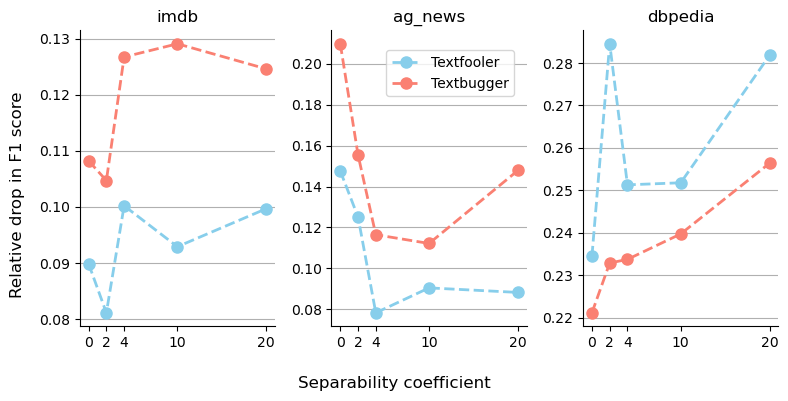

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
for dataset_index, dataset in enumerate(["imdb", "ag_news", "dbpedia"]):
    values_textfooler = []
    values_textbugger = []

    for comment in [
        "separability_0",
        "separability_2",
        "separability_4",
        "separability_10",
        "separability_20",
    ]:
        sub_df = df[
            (df["Model"] == "Prototex")
            & (df["dataset"] == dataset)
            & (df["comments"] == comment)
        ]

        relative_drop_in_f1_textfooler = (
            sub_df[sub_df["dataset type"] == "test - textfooler"][
                "F1 performance"
            ].values[0]
            - sub_df[sub_df["dataset type"] == "adv - textfooler"][
                "F1 performance"
            ].values[0]
        ) / sub_df[sub_df["dataset type"] == "test - textfooler"][
            "F1 performance"
        ].values[
            0
        ]

        relative_drop_in_f1_textbugger = (
            sub_df[sub_df["dataset type"] == "test - textbugger"][
                "F1 performance"
            ].values[0]
            - sub_df[sub_df["dataset type"] == "adv - textbugger"][
                "F1 performance"
            ].values[0]
        ) / sub_df[sub_df["dataset type"] == "test - textbugger"][
            "F1 performance"
        ].values[
            0
        ]

        values_textfooler.append(relative_drop_in_f1_textfooler)
        values_textbugger.append(relative_drop_in_f1_textbugger)

    axs[dataset_index].plot(
        [0, 2, 4, 10, 20],
        values_textfooler,
        label="Textfooler",
        color="skyblue",
        linestyle="dashed",
        marker="o",
        markersize=8,
        linewidth=2,
    )
    axs[dataset_index].plot(
        [0, 2, 4, 10, 20],
        values_textbugger,
        label="Textbugger",
        color="salmon",
        linestyle="dashed",
        marker="o",
        markersize=8,
        linewidth=2,
    )
    axs[dataset_index].set_title(dataset)
    axs[dataset_index].grid(axis="y")

    # remove upper and right spines
    axs[dataset_index].spines["top"].set_visible(False)
    axs[dataset_index].spines["right"].set_visible(False)
    axs[dataset_index].set_xticks([0, 2, 4, 10, 20])

handles, labels = axs[dataset_index].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.49, 0.76))

# Add common x-axis label and y-axis label
fig.supxlabel("Separability coefficient")
fig.supylabel("Relative drop in F1 score")
plt.tight_layout()
plt.savefig("figures/effect_of_separability.png", dpi=300)
plt.show()

### Effect of different components

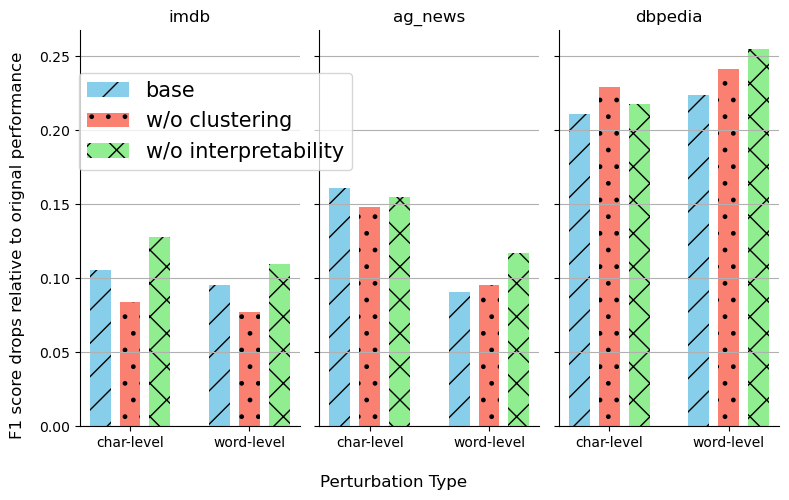

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(8, 5), sharey=True)
for index, dataset in enumerate(["imdb", "ag_news", "dbpedia"]):
    x = df[
        (df["Model"] == "Prototex")
        & (
            df["comments"].isin(
                ["base", "w/o clustering", "separability_0", "w/o interpretability"]
            )
        )
        & (df["dataset"] == dataset)
        & (~df["dataset type"].str.contains("paraphrased"))
    ]

    model_types = ["base", "w/o clustering", "w/o interpretability"]
    values_base = []
    values_clustering = []
    values_interpretability = []
    for attack in ["textbugger", "textfooler"]:
        x_test_base = x[
            (x["dataset type"] == f"test - {attack}") & (x["comments"] == "base")
        ]["F1 performance"].values[0]
        x_adv_base = x[
            (x["dataset type"] == f"adv - {attack}") & (x["comments"] == "base")
        ]["F1 performance"].values[0]

        x_test_clustering = x[
            (x["dataset type"] == f"test - {attack}")
            & (x["comments"] == "w/o clustering")
        ]["F1 performance"].values[0]
        x_adv_clustering = x[
            (x["dataset type"] == f"adv - {attack}")
            & (x["comments"] == "w/o clustering")
        ]["F1 performance"].values[0]

        x_test_interpretability = x[
            (x["dataset type"] == f"test - {attack}")
            & (x["comments"] == "w/o interpretability")
        ]["F1 performance"].values[0]
        x_adv_interpretability = x[
            (x["dataset type"] == f"adv - {attack}")
            & (x["comments"] == "w/o interpretability")
        ]["F1 performance"].values[0]

        values_base.append((x_test_base - x_adv_base) / x_test_base)
        values_clustering.append(
            (x_test_clustering - x_adv_clustering) / x_test_clustering
        )
        values_interpretability.append(
            (x_test_interpretability - x_adv_interpretability) / x_test_interpretability
        )

    width = 0.7

    axs[index].bar(
        [0, 4],
        values_base,
        label="base",
        color="skyblue",
        width=width,
        hatch="/",
    )

    axs[index].bar(
        [1, 5],
        values_clustering,
        label="w/o clustering",
        color="salmon",
        width=width,
        hatch=".",
    )

    axs[index].bar(
        [2, 6],
        values_interpretability,
        label="w/o interpretability",
        color="lightgreen",
        width=width,
        hatch="x",
    )

    # draw the xtick labels in the next line
    axs[index].set_xticks([1, 5])
    axs[index].set_title(dataset)
    # axs[index].set(xlabel="Component removed", ylabel="F1 score change")
    # axs[index].set_ylim([0.2, 0.8])
    # remove the upper and right spines
    axs[index].spines["right"].set_visible(False)
    axs[index].spines["top"].set_visible(False)
    axs[index].grid(axis="y")
    axs[index].set_xticklabels(["char-level", "word-level"])
handles, labels = axs[index].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.1, 0.66), prop={"size": 15})
fig.supxlabel("Perturbation Type")
fig.supylabel("F1 score drops relative to orignal performance")
plt.tight_layout()
plt.savefig("figures/effect_of_diff_components.png", dpi=300)
plt.show()

### Effect of Scaling up the backbone in the PBN

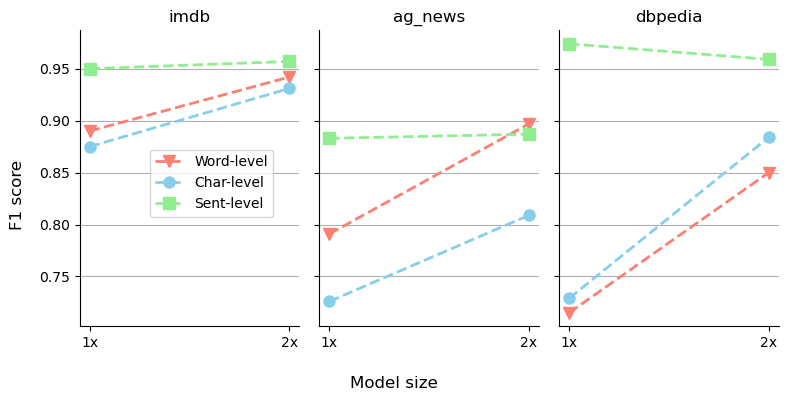

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4), sharey=True, sharex=True)
for index1, model in enumerate(["Prototex"]):
    for index, dataset in enumerate(["imdb", "ag_news", "dbpedia"]):
        x = df[
            (df["comments"].isin(["larger model", " "]))
            & (df["dataset"] == dataset)
            & (df["Model"] == model)
        ]
        x_test_textfooler = x[(x["dataset type"] == f"test - textfooler")]
        x_adv_textfooler = x[x["dataset type"] == f"adv - textfooler"]
        x_test_textbugger = x[(x["dataset type"] == f"test - textbugger")]
        x_adv_textbugger = x[x["dataset type"] == f"adv - textbugger"]
        x_test_paraphrased = x[(x["dataset type"] == f"test - paraphrased")]
        x_adv_paraphrased = x[x["dataset type"] == f"adv - paraphrased"]
        # like red and pale red, and then blue and pale blue

        # for each attack, draw a scatter that shows the change in the f1 score for normal model with comments " " and larger model with comments "larger model"
        axs[index].plot(
            [0, 0.5],
            [
                x_adv_textfooler[x_adv_textfooler["comments"] == " "][
                    "F1 performance"
                ].values[0],
                x_adv_textfooler[x_adv_textfooler["comments"] == "larger model"][
                    "F1 performance"
                ].values[0],
            ],
            label="Word-level",
            color="salmon",
            marker="v",
            markersize=8,
            linewidth=2,
            linestyle="dashed",
        )
        axs[index].plot(
            [0, 0.5],
            [
                x_adv_textbugger[x_adv_textbugger["comments"] == " "][
                    "F1 performance"
                ].values[0],
                x_adv_textbugger[x_adv_textbugger["comments"] == "larger model"][
                    "F1 performance"
                ].values[0],
            ],
            label="Char-level",
            color="skyblue",
            marker="o",
            markersize=8,
            linewidth=2,
            linestyle="dashed",
        )
        axs[index].plot(
            [0, 0.5],
            [
                x_adv_paraphrased[x_adv_paraphrased["comments"] == " "][
                    "F1 performance"
                ].values[0],
                x_adv_paraphrased[x_adv_paraphrased["comments"] == "larger model"][
                    "F1 performance"
                ].values[0],
            ],
            label="Sent-level",
            color="lightgreen",
            marker="s",
            markersize=8,
            linewidth=2,
            linestyle="dashed",
        )

        axs[index].grid(axis="y")
        axs[index].set_title(dataset)
        # write down the x label ticks
        axs[index].set_xticks([0, 0.5], ["1x", "2x"])
        # remove the upper and right spines
        axs[index].spines["right"].set_visible(False)
        axs[index].spines["top"].set_visible(False)

handles, labels = axs[index].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.19, 0.46))
fig.supxlabel("Model size")
fig.supylabel("F1 score")
plt.tight_layout()
plt.savefig("figures/effect_of_size.png", dpi=300)
plt.show()